In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
BASE_DIR = "melanoma"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

print("Train folders:", os.listdir(TRAIN_DIR))
print("Test folders:", os.listdir(TEST_DIR))


Train folders: ['Melanoma', 'NotMelanoma']
Test folders: ['Melanoma', 'NotMelanoma']


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

class_names = train_ds.class_names
class_names


Found 10682 files belonging to 2 classes.
Found 3561 files belonging to 2 classes.


['Melanoma', 'NotMelanoma']

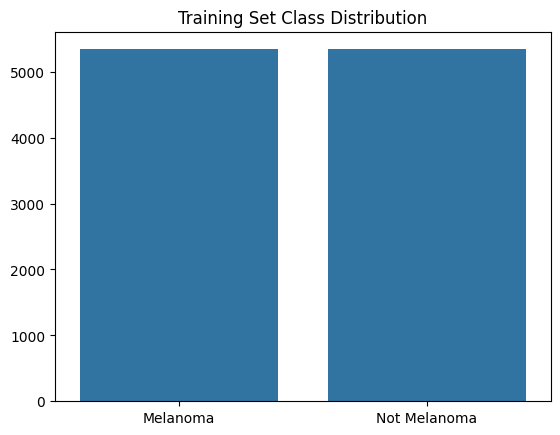

In [6]:
counts = { "Melanoma": len(os.listdir(os.path.join(TRAIN_DIR, "Melanoma"))),
           "Not Melanoma": len(os.listdir(os.path.join(TRAIN_DIR, "NotMelanoma"))) }

sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Training Set Class Distribution")
plt.show()


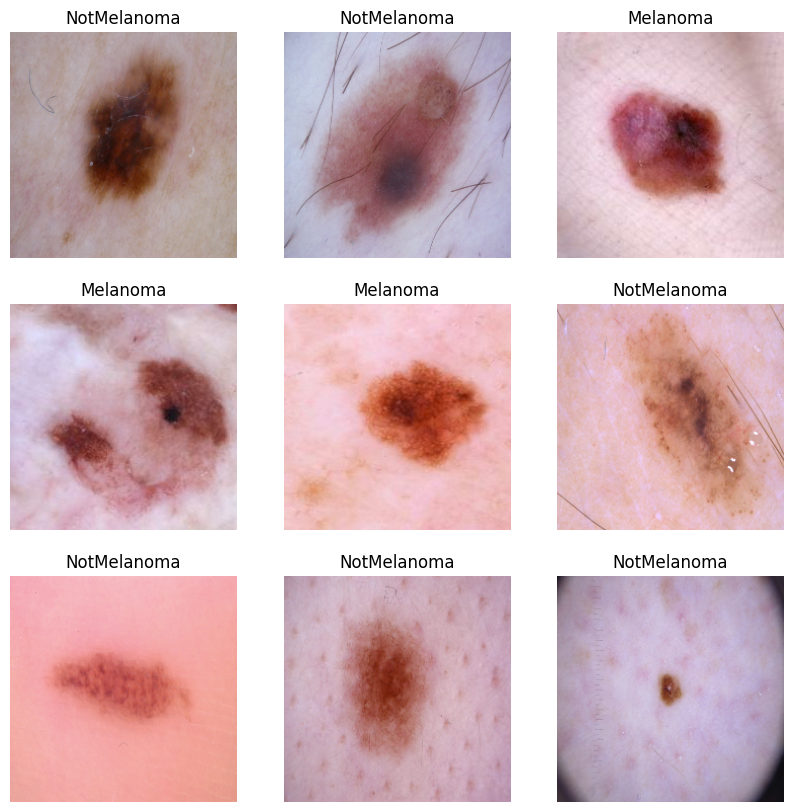

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
base_model = keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # freeze

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


16705208/16705208 [==============================] - 1s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 1281 (5.00

In [10]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)


Epoch 1/10


2025-11-15 11:46:36.453175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 237 of 1000
2025-11-15 11:46:41.481400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


334/334 [==============================] - 200s 522ms/step - loss: 0.2969 - accuracy: 0.8937 - val_loss: 0.2207 - val_accuracy: 0.9284
Epoch 2/10
334/334 [==============================] - 182s 545ms/step - loss: 0.2048 - accuracy: 0.9270 - val_loss: 0.2007 - val_accuracy: 0.9292
Epoch 3/10
334/334 [==============================] - 184s 552ms/step - loss: 0.1893 - accuracy: 0.9298 - val_loss: 0.1937 - val_accuracy: 0.9306
Epoch 4/10
334/334 [==============================] - 208s 624ms/step - loss: 0.1840 - accuracy: 0.9308 - val_loss: 0.1862 - val_accuracy: 0.9284
Epoch 5/10
334/334 [==============================] - 287s 862ms/step - loss: 0.1808 - accuracy: 0.9334 - val_loss: 0.1846 - val_accuracy: 0.9306
Epoch 6/10
334/334 [==============================] - 280s 839ms/step - loss: 0.1762 - accuracy: 0.9330 - val_loss: 0.1832 - val_accuracy: 0.9326
Epoch 7/10
334/334 [==============================] - 302s 905ms/step - loss: 0.1734 - accuracy: 0.9339 - val_loss: 0.1783 - val_accura

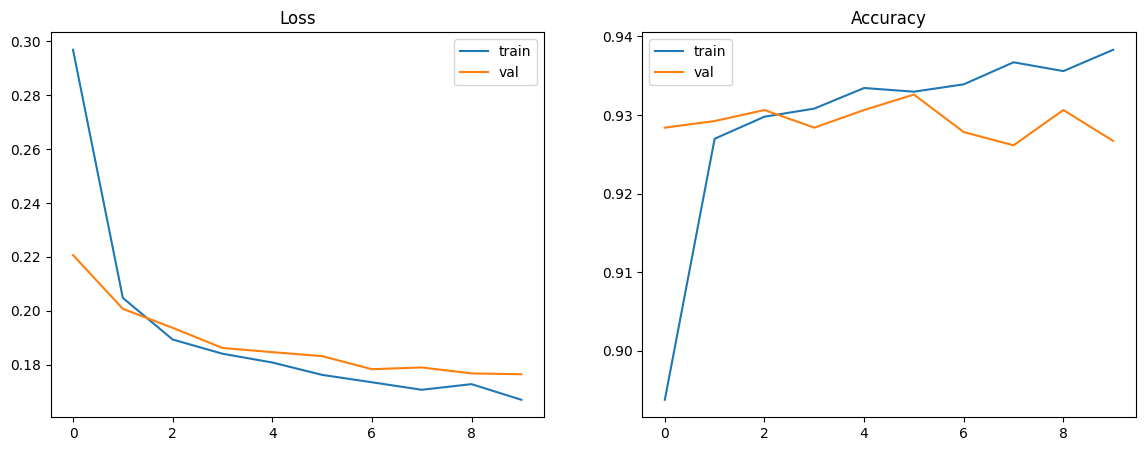

In [12]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.show()


In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_single_image(img_path, model, img_size=(224, 224), class_names=["Melanoma", "Not Melanoma"]):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = keras.applications.efficientnet.preprocess_input(img_array)
    
    pred = model.predict(img_array)[0][0]
    label = class_names[int(pred > 0.5)]
    confidence = pred if pred > 0.5 else 1 - pred
    print(f"Prediction: {label} ({confidence*100:.2f}%)")
    
    plt.imshow(img)
    plt.title(f"{label} ({confidence*100:.2f}%)")
    plt.axis("off")
    plt.show()


1/1 [==============================] - 0s 75ms/step
Prediction: Melanoma (99.37%)


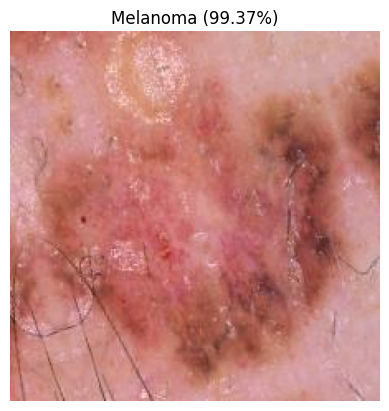

1/1 [==============================] - 0s 39ms/step
Prediction: Not Melanoma (99.69%)


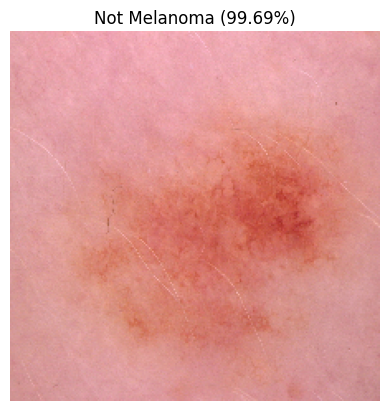

In [17]:
melanoma_img_path = "./melanoma/test/Melanoma/AUG_0_26.jpeg"
not_melanoma_img_path = "./melanoma/test/NotMelanoma/ISIC_0024357.jpg"

predict_single_image(melanoma_img_path, model)
predict_single_image(not_melanoma_img_path, model)


In [ ]:
MODEL_SAVE_PATH = "saved_melanoma_model"
model.save(MODEL_SAVE_PATH)
